# Introduction

Scholar is a framework for document modeling, much like LDA, but with the ability to flexibly incorporate metadata, with some similarity to the structural topic model. It can scale to large numbers of covariates, runs in python, and offers GPU support for fast exploration of a corpus of documents.

In this tutorial, we'll use a toy corpus of political press releases in order to demonstrate the functionality and interface of Scholar.

# Setup

### Code

If you're looking at this tutorial, you have presumably already downloaded/cloned the Scholar repo. If not, you can clone it using: 

`git clone git@github.com:dallascard/scholar.git`

(if you don't have git set up, you can just download the repo from https://github.com/dallascard/scholar)

Scholar has not yet been packaged us as a full python packge. As such, we will just run commands from the scholar directory, so switch into it:

`cd /path/to/scholar`

(the directory that contains this notebook)

### Environment

Create new python environment for running scholar. We recommend using Anaconda, but it is also possible to do this using virtualenv and pip. Assuming you are using conda, run the following three commands, one at a time, and follow the prompts:

`conda create -n scholar python=3`

`source activate scholar`

`conda install ipython notebook numpy=1.15.4 scipy=1.1.0 pandas matplotlib gensim pytorch=1.0.0 torchvision -c pytorch`

You should also now quit this notebook and reload it from with the scholar environment (i.e. after running `source activate scholar` in the shell).

### Data

For this tutorial, we'll be using a subset of the Congressional press release corpus created by Justin Grimmer.

A compressed file with press releases from six senators can be found in this repo. To expand it, run

`tar -xzf tutorial.tar.gz`

which will create a  directory called  `tutorial/CongressPressExpand/`

For those who are interested, the full dataset (Press.tar; 282Mb) can be downloaded from https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/14596

### A note about reproducibility

The results in this notebook should be basically reproducible, however, it seems that this depends on having the same version of certain packages. The code will still work with different versions, but the resulting topics may be different. Moreover, the results will be slightly different if using a GPU, and there may also be very small numerical differences on different machines.

The results given here were obtained using the following environment:
- python 3.7.1
- pytorch 1.0.0
- numpy 1.15.4

# Data Import

To use scholar, it is necessary to get the data into the proper format. To do this, the easiest thing to do is to write a script to convert the documents into a single file, where each line corresponds to one document, represented as a JSON object. Each JSON object should have at least one field called "text", but it can also contain other metadata fields.

We have included a script to convert a subset of the Senatorial press releases into this format, which can be used as a starting point for your own project.

If running this from the command line, it would be run as

`python import_congress_press.py tutorial/CongressPressExpand tutorial/congress/`

Since we are running this in a notebook, we will run it by importing the package, and calling the `main()` function with the corresponding arguments in a list.

In [5]:
import import_congress_press
script = 'import_congress_press.py'
args = 'tutorial/CongressPressExpand tutorial/congress'
print("python", script, args)
import_congress_press.main(args.split())

python import_congress_press.py tutorial/CongressPressExpand tutorial/congress
274 files from Sanders
709 files from Obama
358 files from Klobuchar
293 files from McCain
614 files from Graham
235 files from Coburn
Saving files to tutorial/congress
Done!


This creates two files in the output directory (`/tutorial/congress/`):
- `train.jsonlist` contains one press release per line, in JSON format, including fields for the text of the press release, as well as senator name, party, date, year, and month
- `train.score.csv` contains DW-nominate scores for 6 senators from the 110th congress, with one score for each document in `train.jsonlist` (in the same order).

To inspect a document, we can use the `json` library to load it

In [6]:
import os
import json
with open(os.path.join('tutorial', 'congress', 'train.jsonlist')) as f:
    lines = f.readlines()
first_doc = json.loads(lines[0])
for key, value in first_doc.items():
    print(key, ':', value)

id : 10Apr2007Sanders238.txt
text : SEIZE THE OPPORTUNITY FOR MAJOR BREAKTHROUGHS IN HEALTH CARE   The Senate this week is considering a bill, cosponsored by Sen. Bernie Sanders, that would expand and encourage federal funding of human embryonic stem cell research. President Bush in 2001 cut off federal funding for research involving new embryonic stem cells, which has dramatically stalled this critical area of medical research.      "My hope is that, as a result of increased pressure from scientists, physicians and the American people, the president will change his position or, if he does not, that the Congress will have enough votes to override his veto and establish unrestricted federal funding for stem cell research," Sanders said. "The potential is now available for major breakthroughs in Parkinson's disease, Alzheimer's, diabetes, spinal cord injury, stroke, heart disease and many other illnesses. We must seize the opportunity."     View a copy of the Bill - S. 5 at http://sander

If we had documents that we wanted to use as a test set, we could create a `test.jsonlist` object in the same manner.

# Preprocessing

The next step is to use a preprocessing script we have provided to convert the documents from JSON format into a numerical representation. It works by creating a vocabulary, filtering out numbers, punctuation, and some other tokens, and saving the document-term count matrix. 

The preprocessing script can also simultaneously pull out various metadata attributes (like author or year) from the JSON objects, and convert them into one-hot representations, which will be saved as .csv files.

For other types of metadata, such as continously-valued data, you will need to create the corresponding .csv files manually, as we did above for `train.score.csv`. All that matters is that the order of the rows is the same as the the order of documents in `train.jsonlist`. Also, scholar will expect the file name to be `train.field_name.csv` (or "test" rather than "train" for test data).

To see the full set of options for any command, try running it with the `-h` option. Again, in the shell, this would be run as:

`python preprocess_data.py -h`

In [7]:
import preprocess_data
args = '-h'
print("python preprocess_data.py -h")
preprocess_data.main([args])

python preprocess_data.py -h
Usage: ipykernel_launcher.py train.jsonlist output_dir

Options:
  -h, --help            show this help message and exit
  --label=LABEL         field(s) to use as label (comma-separated):
                        default=none
  --test=TEST           Test data (test.jsonlist): default=none
  --train-prefix=TRAIN_PREFIX
                        Output prefix for training data: default=train
  --test-prefix=TEST_PREFIX
                        Output prefix for test data: default=test
  --stopwords=STOPWORDS
                        List of stopwords to exclude [None|mallet|snowball]:
                        default=snowball
  --min-doc-count=MIN_DOC_COUNT
                        Exclude words that occur in less than this number of
                        documents
  --max-doc-freq=MAX_DOC_FREQ
                        Exclude words that occur in more than this proportion
                        of documents
  --keep-num            Keep tokens made of only numbers

SystemExit: 0

Here, we'll tell it to only use words that occur in at least 90 documents, which will give us a vocabulary of about 1000 words (excluding stopwords). This will help the model run faster, but using a larger vocabulary (2000 or 5000 words, might lead to much richer topics). Alternatively, we could set the vocabulary size directly, using `--vocab-size`

We'll also tell it to create the label matrices for the various metadata attributes, which we provide in a comma-separated list (without spaces). As a reminder, it will assume that each of these metadata names will be a field in each JSON document object.

In [8]:
script = 'preprocess_data.py'
args = 'tutorial/congress/train.jsonlist tutorial/congress --min-doc-count 90 --label senator,party,year,month,date'
print("python", script, args)
preprocess_data.main(args.split())

python preprocess_data.py tutorial/congress/train.jsonlist tutorial/congress --min-doc-count 90 --label senator,party,year,month,date
Using snowball stopwords
Reading data files
Found 2483 training documents
Found label senator with 6 classes
Found label party with 2 classes
Found label year with 4 classes
Found label month with 12 classes
Found label date with 918 classes
Parsing 2483 documents
Size of full vocabulary=22131
Selecting the vocabulary
Vocab size after filtering = 1021
Final vocab size = 1021
Most common words remaining: senator washington today said senate contact press also current date
Converting to count representations
Size of train document-term matrix: (2483, 1021)
0 words missing from training data
Done!


This preprocessing script creates several files, some uesd by Scholar, and some designed for other software, like Mallet. The files of interest are:
- `train.npz`, which contains a (D x V) sparse matrix of document word counts,
- `train.vocab.json`, which contains the vocabualry as a JSON object, and;
- files like `train.year.csv`, which contain the year corresponding to each document, in a matrix of size (D x C), where C is the number of distinct covariate values (e.g. years)

Let's look at a couple of files:

In [9]:
# load the vocabualry
with open(os.path.join('tutorial', 'congress', 'train.vocab.json')) as f:
    vocab = json.load(f)
print("First few words in the vocbulary:")
print(vocab[:6] + ['...'])

First few words in the vocbulary:
['ability', 'able', 'abuse', 'access', 'according', 'accountability', '...']


In [10]:
# load a covariate file
import pandas as pd
print("Start of a covariate file (train.year.csv):")
df = pd.read_csv(os.path.join('tutorial', 'congress', 'train.year.csv'), header=0, index_col=0)
print(df.head())

Start of a covariate file (train.year.csv):
                         2005  2006  2007  2008
10Apr2007Sanders238.txt     0     0     1     0
10Apr2008Sanders2.txt       0     0     0     1
10Apr2008Sanders3.txt       0     0     0     1
10Dec2007Sanders61.txt      0     0     1     0
10May2007Sanders212.txt     0     0     1     0


Note that if we had a test corpus, we could simultaneously process it by adding the `--test` option to our call to `preprocess_data` (with the path to `test.jsonlist`).

# Running Scholar

We are now ready to run Scholar!

To start off, let's just run a basic topic model, without any metadata. We just need to specify the input directory,  and it will look for the `train.npz` file, as well as `train.vocab.json`. 

Here, we'll also tell it to use 10 topics (`-k`), tell it only to run for 50 epochs (`--epochs 50`), and to use a random 1/10th of the data as a dev/validation set to monitor the fit (`--dev-folds 10`). 

In [53]:
import run_scholar
script = 'run_scholar.py'
args = 'tutorial/congress/ -k 10 --epochs 50 --dev-folds 10 --seed 42'
print("python", script, args)
run_scholar.main(args.split())

python run_scholar.py tutorial/congress/ -k 10 --epochs 50 --dev-folds 10 --seed 42
Loading data
Loaded 2483 documents with 1021 features
Found 2483 non-empty documents
Computing background frequencies
Min/max word counts in training data: 90 5080
Network architecture:
embedding_dim: 300
n_topics: 10
vocab_size: 1021
label_type: None
n_labels: 0
n_prior_covars: 0
n_topic_covars: 0
l1_beta_reg: 0.0
l1_beta_c_reg: 0.0
l1_beta_ci_reg: 0.0
l2_prior_reg: 0.0
classifier_layers: 1
use_interactions: False
Optimizing full model
Epoch: 10 cost= 1132.716733519
Epoch: 10; Dev perplexity = 983.5218
Epoch: 20 cost= 1128.470428945
Epoch: 20; Dev perplexity = 857.5101
Epoch: 30 cost= 1117.978690401
Epoch: 30; Dev perplexity = 798.9625
Epoch: 40 cost= 1090.164661109
Epoch: 40; Dev perplexity = 756.3840
Background frequencies of top words:
obama senator bill said senate today graham washington press president
[0.01298087 0.01290677 0.00907639 0.00863688 0.00794695 0.00677663
 0.00639589 0.00639589 0.006

To display this a bit more cleanly, let's load the output and look at it.

By default, the output of the model is saved to a directory called `output`, but that can be changed using the `-o` option (remember to use `-h` to see all options).

First, let's inspect the background frequencies of the most common words (the log-frequencies are computed and saved)

In [31]:
import json
import numpy as np

# load the background log-frequencies
bg = np.load('output/bg.npz')['bg']

# load the vocabualry
with open('output/vocab.json') as f:
    vocab = json.load(f)

# sort terms by log-frequency
order = np.argsort(bg)

# print the most common words 
for i in range(1, 16):
    index = order[-i]
    print(vocab[index], np.exp(bg[index]))

obama 0.012980873
senator 0.012906771
bill 0.0090763895
said 0.008636881
senate 0.007946953
today 0.0067766286
graham 0.00639589
washington 0.00639589
press 0.00609181
president 0.0060100416
legislation 0.005859277
health 0.0057085156
federal 0.005634414
barack 0.005565421
million 0.0052051255


This seems like about what we would expect for the most common words, including common words, like "said", corpus-specific words, like "senator", and the names of some of the Senators we have included.

Typically in topic models, we might need to remove stopwords to get good topics, but in Scholar the background term means that we don't particularly need to worry about it. (Note that the prepocessing script removed some very common words like "the", but they could equally have been left in).

Now let's look at the topics:

In [33]:
from run_scholar import print_top_words

# load the stored (K x V) topic matrix (stored in a compressed numpy format)
beta = np.load(os.path.join('output', 'beta.npz'))['beta']
print_top_words(beta, vocab, n_pos=7, n_neg=0);

0: barack contact statement release petitions initiated immediate ; sparsity=0.0000
1: iraq president american war time one iraqi ; sparsity=0.0000
2: washington mccain browse statement record contact following ; sparsity=0.0000
3: press graham awarded releases grants fire browse ; sparsity=0.0000
4: energy renewable klobuchar fuel said fuels gas ; sparsity=0.0000
5: veterans care health obama members service legislation ; sparsity=0.0000
6: bill funding million klobuchar year senate said ; sparsity=0.0000
7: press releases browse carolina kevin relases record ; sparsity=0.0000
8: obama barack federal durbin state assistance lead ; sparsity=0.0000
9: year percent tax president americans income american ; sparsity=0.0000


There is some order here, with certain words going together, like "bill" and "funding", or "press" and "release", but overall these topics are not great.

One problem is that we are still seeing names like "Obama" and "Barack" appearing in the topics, which is not quite what we want. To deal with this, let's add topic covariates, to introduce explicit term for each Senator, to collect the words that are more or less common overall for each one.

We'll also let the model run for more epochs, to help it converge.

## Adding covariates

Here we introduce the `--topic-covars` option, which introduces topic-like deviations for observed one-hot covariates. Thus, in addition to the 10 topics, we will here get 6 more vectors of word weights, one for each Senator.

When we add the option `--topic-covars senator`, it will look for a file called `train.senator.csv`, with one row for each document, in the same order as `train.jsonlist`. (As a reminder, this file was created by `preprocess_data.py`).

In [12]:
script = 'run_scholar.py'
args = 'tutorial/congress/ -k 10 --epochs 150 --dev-folds 10 --seed 42 --topic-covars senator'
print("python", script, args)
run_scholar.main(args.split())

python run_scholar.py tutorial/congress/ -k 10 --epochs 150 --dev-folds 10 --seed 42 --topic-covars senator
Loading data
Loaded 2483 documents with 1021 features
Found 2483 non-empty documents
Loading covariates from tutorial/congress/train.senator.csv
Computing background frequencies
Min/max word counts in training data: 90 5080
Network architecture:
embedding_dim: 300
n_topics: 10
vocab_size: 1021
label_type: None
n_labels: 0
n_prior_covars: 0
n_topic_covars: 6
l1_beta_reg: 0.0
l1_beta_c_reg: 0.0
l1_beta_ci_reg: 0.0
l2_prior_reg: 0.0
classifier_layers: 1
use_interactions: False
Optimizing full model
Epoch: 10 cost= 1164.963810385
Epoch: 10; Dev perplexity = 936.3517
Epoch: 20 cost= 1131.093831926
Epoch: 20; Dev perplexity = 823.7403
Epoch: 30 cost= 1098.462667785
Epoch: 30; Dev perplexity = 724.9147
Epoch: 40 cost= 1048.331285174
Epoch: 40; Dev perplexity = 674.0774
Epoch: 50 cost= 1079.597725068
Epoch: 50; Dev perplexity = 636.2749
Epoch: 60 cost= 1076.581337607
Epoch: 60; Dev perpl

Again, let's load the topics and have a look:

In [19]:
beta = np.load('output/beta.npz')['beta']
print_top_words(beta, vocab, n_pos=7, n_neg=0);

0: statement initiated opinion following newsletters polls petitions ; sparsity=0.0000
1: energy gas oil renewable fuels reduce fire ; sparsity=0.0000
2: consumer safety commerce commission lead children consumers ; sparsity=0.0000
3: income tax insurance low health americans priorities ; sparsity=0.0000
4: troops iraq war course mission iraqi terror ; sparsity=0.0000
5: emergency request residents durbin recovery damage federal ; sparsity=0.0000
6: nomination supreme judge judiciary justice rights man ; sparsity=0.0000
7: earmarks immigration transparency judiciary reform let point ; sparsity=0.0000
8: veterans affairs defense afghanistan military members returning ; sparsity=0.0000
9: announces county project announced projects awarded development ; sparsity=0.0000


These look much better! There are fairly clear topics for the energy, Iraq, infrastructure, etc.

In addition, we can load the vectors that have been learned for each Senator, which will be saved in a file called `beta_c.npz`.

In [22]:
topic_covars = np.load(os.path.join('output', 'beta_c.npz'))
weights = topic_covars['beta']
names = topic_covars['names']
print_top_words(weights, vocab, topic_names=names, n_pos=7, n_neg=0);

Coburn: coburn tom added citizen spending released subcommittee ; sparsity=0.0000
Graham: wes releases press hickman relases graham date ; sparsity=0.0000
Klobuchar: minnesota klobuchar amy commerce renewable businesses incentives ; sparsity=0.0000
McCain: mccain john simply freedom though record authorized ; sparsity=0.0000
Obama: release immediate barack illinois pursuant julian ortiz ; sparsity=0.0000
Sanders: vermont bernie sanders read http sen told ; sparsity=0.0000


These are clearly about right, in that the Senator's names and/or states are appearing in the right vectors. It is hard to make sense of some of these, but they appear to doing the right thing in terms of pulling the Senator-specific terms out of the topics.

Note that if we had used the full dataset, we could easily extend the covariates to include a variable for each Senator without difficulty, which would be quite slow to run in the structural topic model.

## Visualizing results

Let's load the resulting document-topic proportions for the training data, and look a random example. 


10Apr2008Sanders2.txt
SENATE ADOPTS SANDERS VETERANS PROVISION IN HOUSING BILL   The Senate today put finishing touches on housing stimulus legislation, adding a $57 million proposal authored by Senator Bernie Sanders (I-Vt.) that would increase federal grants to help disabled veterans adapt their homes.     "With so many soldiers coming back from Iraq with disabilities, it is absolutely imperative that we make sure they have as normal a life as possible and that certainly includes adapting their homes to meet their needs," Sanders said.    The final bill, which the Senate approved 84 to 12, also included energy tax credits cosponsored by Sanders that would promote renewable energy and energy efficiency. It would extend expiring federal tax benefits for investment in solar, wind and other sustainable energy sources.    Sanders also was the lead cosponsor of a successful amendment by Senator Patrick Leahy (D-Vt.) that would guarantee Vermont a $20 million share of $4 billion in communit

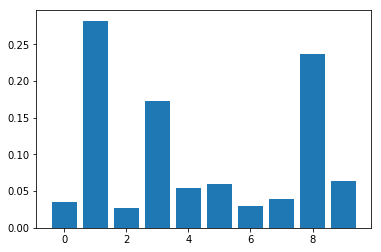

In [28]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load the matrix with topic proportions for each document (note that this excludes those in the dev set).
npz = np.load(os.path.join('output', 'theta.train.npz')) 
ids = npz['ids']
theta = npz['theta']
n_docs, n_topics = theta.shape

index = 1
# plot the proportion of each topic in the first document
fig, ax = plt.subplots()
ax.bar(range(n_topics), theta[index, :])

# find the original line corresponding to this document, and display the text
print(ids[index])
for line in lines:
    doc = json.loads(line)
    if doc['id'] == ids[index]:
        print(doc['text'])
        break


This seems about right! The press release combines the topics of veterans affairs (topic 8), renewable energy (topic 1) and tax reform (topic 3). We might quibble with what the correct proportions of these topics should be, but they are cleary the dominant elements of the text, given the topics that the model has learned.

Now, let's plot the relative prevalance of each topics for each Senator.

Because scholar split the training data into a training set and a dev set, we need to match up the output to the original senator variables.

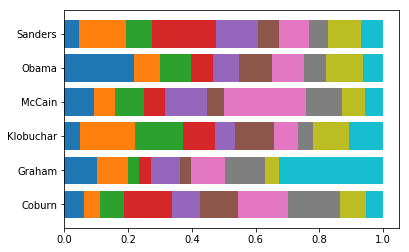

In [29]:

# load the senator variable for all the documents
senators_df = pd.read_csv(os.path.join('tutorial', 'congress', 'train.senator.csv'), header=0, index_col=0)
senators = senators_df.columns

# pull out a subset corresponding to the ids from above
train_subset = senators_df.loc[ids]
n_docs, n_senators = train_subset.shape

# plot the average senator-topic proportions
fig, ax = plt.subplots()
lefts = np.zeros(n_senators)
for k in range(n_topics):
    vals = []
    for senator in senators:
        vals.append(np.mean(theta[train_subset[senator] == 1, k]))

    ax.barh(range(n_senators), vals, left=lefts)
    lefts += np.array(vals)
    
ax.set_yticks(range(n_senators))
ax.set_yticklabels(senators)
plt.show();

This seems to have at least some face validity, with, for example, Amy Klobuchar writing the most about about energy/environment issues (topic 1), and Bernie Sanders writing the most about taxes and insurance (topic 3). It also appears that John McCain writes the most about the supreme court (topic 6), and Lindsay Graham devotes a lot of text to announcing grants (topic 9), but more expertise would be required to evaluate these findings.

## Initializing with pretrained word vectors

Emperically, we found that initializing the model with pretrained word vectors led to greater coherence in the topics. If you are interested in trying this, it is necessary to download the pretrained word2vec vectors from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing

Once this is done, and these have been saved somewhere, we can add the `--w2v` option to the model, with a path to the vector file. Here, we'll assume it's in the local directory.

Note that it takes some time to load the word vectors, so we'll just try this once for illustration purposes.

In [36]:
script = 'run_scholar.py'
args = 'tutorial/congress/ -k 10 --epochs 150 --dev-folds 10 --seed 42 --topic-covars senator --w2v ./vectors/GoogleNews-vectors-negative300.bin'
print("python", script, args)
run_scholar.main(args.split())

python run_scholar.py tutorial/congress/ -k 10 --epochs 150 --dev-folds 10 --seed 42 --topic-covars senator --w2v ./vectors/GoogleNews-vectors-negative300.bin
Loading data
Loaded 2483 documents with 1021 features
Found 2483 non-empty documents
Loading covariates from tutorial/congress/train.senator.csv
Computing background frequencies
Min/max word counts in training data: 90 5080
Network architecture:
embedding_dim: 300
n_topics: 10
vocab_size: 1021
label_type: None
n_labels: 0
n_prior_covars: 0
n_topic_covars: 6
l1_beta_reg: 0.0
l1_beta_c_reg: 0.0
l1_beta_ci_reg: 0.0
l2_prior_reg: 0.0
classifier_layers: 1
use_interactions: False
Loading word vectors
Found embeddings for 1012 words
Optimizing full model
Epoch: 10 cost= 1147.214786948
Epoch: 10; Dev perplexity = 259334511854659408208712030984883579618603079151925990842278890761964410975977487392740435859689074562890399630372673782022144.0000
Epoch: 20 cost= 1126.638549532
Epoch: 20; Dev perplexity = 947.9900
Epoch: 30 cost= 1070.7965538

In [37]:
beta = np.load('output/beta.npz')['beta']
print_top_words(beta, vocab, n_pos=8, n_neg=0);

0: recovery assistance federal disaster funds damage emergency residents ; sparsity=0.0000
1: rights statement nomination following judge court position supreme ; sparsity=0.0000
2: court judge think just legal agree supreme judiciary ; sparsity=0.0000
3: statement following released vietor barack gibbs obama contact ; sparsity=0.0000
4: energy gas fuel oil climate fuels renewable production ; sparsity=0.0000
5: iraq troops iraqi course war forces region terror ; sparsity=0.0000
6: grants departments awarded fire grant tools safety equipment ; sparsity=0.0000
7: care million health funding education children research affordable ; sparsity=0.0000
8: soldiers veterans members care returning benefits military defense ; sparsity=0.0000
9: announced announces press releases bishop south commerce awarded ; sparsity=0.0000


In this case, the results seem quite similar, but it might be more beneficial when working with a larger vocabualry (and therefore words which occur less frequently).

## Adding more covariates

Note that we can easily include additional covarites in the same way as we did for senators. Let's try also including covariates for year and month. Just include them in a comma-separated list (again, without spaces).

In [39]:
script = 'run_scholar.py'
args = 'tutorial/congress/ -k 10 --epochs 150 --dev-folds 10 --seed 42 --topic-covars senator,year,month'
print("python", script, args)
run_scholar.main(args.split())

python run_scholar.py tutorial/congress/ -k 10 --epochs 150 --dev-folds 10 --seed 42 --topic-covars senator,year,month
Loading data
Loaded 2483 documents with 1021 features
Found 2483 non-empty documents
Loading covariates from tutorial/congress/train.senator.csv
Loading covariates from tutorial/congress/train.year.csv
Loading covariates from tutorial/congress/train.month.csv
Computing background frequencies
Min/max word counts in training data: 90 5080
Network architecture:
embedding_dim: 300
n_topics: 10
vocab_size: 1021
label_type: None
n_labels: 0
n_prior_covars: 0
n_topic_covars: 22
l1_beta_reg: 0.0
l1_beta_c_reg: 0.0
l1_beta_ci_reg: 0.0
l2_prior_reg: 0.0
classifier_layers: 1
use_interactions: False
Optimizing full model
Epoch: 10 cost= 1144.751566432
Epoch: 10; Dev perplexity = 867.6086
Epoch: 20 cost= 1116.071242091
Epoch: 20; Dev perplexity = 818.4166
Epoch: 30 cost= 1086.788289115
Epoch: 30; Dev perplexity = 745.8821
Epoch: 40 cost= 1036.548577976
Epoch: 40; Dev perplexity = 6

Now if we load the covariate vectors, we will also see some temporal patterns in word frequencies. The ones here don't seem all that compelling, but perhaps more data is needed.

In [40]:
topic_covars = np.load(os.path.join('output', 'beta_c.npz'))
weights = topic_covars['beta']
names = topic_covars['names']
print_top_words(weights, vocab, topic_names=names, n_pos=8, n_neg=0);

Coburn: room coburn per tom citizen released spending regarding ; sparsity=0.0000
Graham: bishop south relases wes grant graham releases hickman ; sparsity=0.0000
Klobuchar: klobuchar minnesota consumer prices consumers commerce serves bipartisan ; sparsity=0.0000
McCain: mccain record browse john appropriations consequences bills democracy ; sparsity=0.0000
Obama: illinois julian obama tommy barack pursuant gibbs vietor ; sparsity=0.0000
Sanders: bernie vermont http sanders visit sen read news ; sparsity=0.0000
2005: julian gibbs tommy vietor green announces supreme court ; sparsity=0.0000
2006: tommy vietor gibbs julian terrorists robert credit terror ; sparsity=0.0000
2007: labolt ben brundage iraq amy consequences troops sanders ; sparsity=0.0000
2008: newsletters initiated michael ortiz petitions polls alerts opinion ; sparsity=0.0000
Apr: april location prices price temporary drug lower clearly ; sparsity=0.0000
Aug: august receive grant purchase transportation writing announce i

## Interactions

Alternatively, we can include interactions between covariates and topics.

Here, let's try using a covariate for party membership, rather than for each Senator, and include interactions between topics and party. To do this, just include the `--interactions` options. 

In [45]:
script = 'run_scholar.py'
args = 'tutorial/congress/ -k 10 --epochs 150 --dev-folds 10 --seed 99 --topic-covars party --interactions'
print("python", script, args)
run_scholar.main(args.split())

python run_scholar.py tutorial/congress/ -k 10 --epochs 150 --dev-folds 10 --seed 99 --topic-covars party --interactions
Loading data
Loaded 2483 documents with 1021 features
Found 2483 non-empty documents
Loading covariates from tutorial/congress/train.party.csv
Computing background frequencies
Min/max word counts in training data: 88 5075
Network architecture:
embedding_dim: 300
n_topics: 10
vocab_size: 1021
label_type: None
n_labels: 0
n_prior_covars: 0
n_topic_covars: 2
l1_beta_reg: 0.0
l1_beta_c_reg: 0.0
l1_beta_ci_reg: 0.0
l2_prior_reg: 0.0
classifier_layers: 1
use_interactions: True
Optimizing full model
Epoch: 10 cost= 1154.104391691
Epoch: 10; Dev perplexity = 1038.3428
Epoch: 20 cost= 1109.740894155
Epoch: 20; Dev perplexity = 954.6553
Epoch: 30 cost= 1104.557029502
Epoch: 30; Dev perplexity = 778.1132
Epoch: 40 cost= 1070.655842553
Epoch: 40; Dev perplexity = 702.9757
Epoch: 50 cost= 1089.706998479
Epoch: 50; Dev perplexity = 669.3897
Epoch: 60 cost= 1074.122579348
Epoch: 60

First, let's look at the vectors learned for each party, then the topics, then the interactions.

In [46]:
topic_covars = np.load(os.path.join('output', 'beta_c.npz'))
weights = topic_covars['beta']
names = topic_covars['names']
print_top_words(weights, vocab, topic_names=names, n_pos=8, n_neg=0);

D: brundage efficient tuesday oil veterans vietor fuels children ; sparsity=0.0000
R: releases demint graham mccain kevin grant browse grants ; sparsity=0.0000


In [47]:
beta = np.load(os.path.join('output', 'beta.npz'))['beta']
print_top_words(beta, vocab, n_pos=8, n_neg=0);

0: iraq armed mission terrorists war troops forces reports ; sparsity=0.0000
1: durbin announce respond residents awarded supports assistance department ; sparsity=0.0000
2: earmarks bills income insurance costs provisions fund health ; sparsity=0.0000
3: armed veterans families army back returning men duty ; sparsity=0.0000
4: coburn room sanders citizen lower bernie tom vermont ; sparsity=0.0000
5: announces announced bishop wes awarded lead relases press ; sparsity=0.0000
6: court judiciary statement nomination supreme ortiz newsletters judge ; sparsity=0.0000
7: fuel fuels renewable production sources oil illegal alternative ; sparsity=0.0000
8: democracy troops iraq freedom war region resolution statement ; sparsity=0.0000
9: river land project development facility klobuchar minnesota water ; sparsity=0.0000


In [48]:
interactions = np.load(os.path.join('output', 'beta_ci.npz'))
weights = interactions['beta']
names = topic_covars['names']
names = [str(k) + ':' + c for k in range(10) for c in names]
print_top_words(weights, vocab, topic_names=names, n_pos=8, n_neg=0);

0:D: reports defense service armed review members military receiving ; sparsity=0.0000
0:R: terrorists rather beginning mission iraq just iraqi region ; sparsity=0.0000
1:D: durbin illinois newsletters request dear affected ortiz dick ; sparsity=0.0000
1:R: grants amount awarded supports announce training kind demint ; sparsity=0.0000
2:D: low program insurance families income affordable housing relief ; sparsity=0.0010
2:R: earmarks rather coburn unfortunately largest included projects contains ; sparsity=0.0000
3:D: returning veterans minnesota klobuchar affairs soldiers field lives ; sparsity=0.0000
3:R: armed defense terrorism freedom terror country force part ; sparsity=0.0000
4:D: sanders bernie vermont told http lower paying news ; sparsity=0.0000
4:R: coburn room citizen per tom spending released agencies ; sparsity=0.0000
5:D: consumer lead safety dear sincerely text commission consumers ; sparsity=0.0000
5:R: hickman lindsey kevin awarded bishop announces record wes ; sparsit

The basic topics here are now perhaps less good, but the interaction do seem to capture something about how the different parties talk about certain issues. For example, for topic 0 (Iraq), The Democrat version emphasizes reports and defense, whereas the Republican version is more about terrorsm. More data (from all the senators) would give us a much better approxaimation of this.

## Adding labels

In addition to covariates, we can also introduce labels, which are predicted from the topics that are learned. Although they only introduce a subtle influence on the topic, we are effectively learning a classifier and a topic model simultaneously.

Here, let's try predicting the party of a press release from the topics. We'll also try using slightly more topics this time.

In [50]:
script = 'run_scholar.py'
args = 'tutorial/congress/ -k 12 --epochs 150 --dev-folds 10 --seed 42 --topic-covars senator,month --label party'
print("python", script, args)
run_scholar.main(args.split())

python run_scholar.py tutorial/congress/ -k 12 --epochs 150 --dev-folds 10 --seed 42 --topic-covars senator,month --label party
Loading data
Loaded 2483 documents with 1021 features
Found 2483 non-empty documents
Loading labels from tutorial/congress/train.party.csv
Found 2 labels
Loading covariates from tutorial/congress/train.senator.csv
Loading covariates from tutorial/congress/train.month.csv
Train label proportions: [0.54007249 0.45992751]
Computing background frequencies
Min/max word counts in training data: 90 5080
Network architecture:
embedding_dim: 300
n_topics: 12
vocab_size: 1021
label_type: None
n_labels: 2
n_prior_covars: 0
n_topic_covars: 18
l1_beta_reg: 0.0
l1_beta_c_reg: 0.0
l1_beta_ci_reg: 0.0
l2_prior_reg: 0.0
classifier_layers: 1
use_interactions: False
Optimizing full model
Epoch: 10 ; cost = 1147.348687430 ; training accuracy (noisy) = 0.666666667
Epoch: 10; Dev perplexity = 937.0897; Dev accuracy = 0.7621
Epoch: 20 ; cost = 1115.941902178 ; training accuracy (noi

First let's look at the topics as usual

In [51]:
beta = np.load(os.path.join('output', 'beta.npz'))['beta']
print_top_words(beta, vocab, n_pos=8, n_neg=0);

0: transparency taxpayers accountability taxpayer financial dollars companies federal ; sparsity=0.0000
1: lead products consumer commission trade safety dangerous free ; sparsity=0.0000
2: health care insurance costs tax income priorities americans ; sparsity=0.0000
3: projects recovery disaster assistance damage counties infrastructure funds ; sparsity=0.0000
4: veterans returning benefits affairs defense members guard duty ; sparsity=0.0000
5: announces relases record announced press browse releases wes ; sparsity=0.0000
6: grants awarded training departments grant announce equipment receive ; sparsity=0.0000
7: supreme court judge don judiciary values let legal ; sparsity=0.0000
8: energy gas renewable oil environment vehicles fuel fuels ; sparsity=0.0000
9: immigration troops iraq illegal border security war failed ; sparsity=0.0000
10: sincerely letter dear text workers writing sent hearing ; sparsity=0.0000
11: statement pursuant newsletters ortiz alerts polls petitions released

Now let's look at which topics predict Democrat vs Republican.

In [52]:
npz = np.load('output/topics_to_labels.npz')
probs = npz['probs']
label_names = npz['label']
n_topics, n_labels = probs.shape
print("Labels:", ' '.join([name for name in label_names]))
for k in range(n_topics):
    output = str(k) + ': '
    for i in range(n_labels):
        output += '%.4f ' % probs[k, i]
    print(output)


Labels: D R
0: 0.5540 0.4460 
1: 0.6336 0.3664 
2: 0.7252 0.2748 
3: 0.6767 0.3233 
4: 0.8098 0.1902 
5: 0.0099 0.9901 
6: 0.0651 0.9349 
7: 0.1596 0.8404 
8: 0.8844 0.1156 
9: 0.2040 0.7960 
10: 0.9209 0.0791 
11: 0.9858 0.0142 


These numbers show the probability (according to the model) that a document entirely about a single topic is from a Democrat vs a Republican. Of course, in practice, most documents will be represented as a mixture of topics, and both parties talk about all topics to some degree.

More expertise would be useful in trying to interpret whether the model is doing something reasonable here, but at least some parts seem to line up (e.g. Democrats talking more about health care (topic 2) and Republicans talking more about illegal immigrtion / Iraq (topic 9), but others seem to be overfitting to particular people (e.g. topics 5, 6, and 11). As above, using data from more Senators would be very useful here.

Ultimately, exploration of different models is requried to figure out what is best for your application. Also, remember than trying a different random seed will give you different results.